Types.jl import

In [1]:
# Constants
const two_pi = 2π

type LatticeSite
    A::Array{Float64,1}  # Fluctuating vector potential
    θ⁺::Float64 # Phase of the + component
    θ⁻::Float64 # Phase of the - component
    u⁺::Float64 # Amplitude of + component
end
type State
    lattice::Array{LatticeSite,2}  # Numerical lattice
    γ::Float64    # Order parameter amplitude
    g::Float64    # Gauge coupling
    ν::Float64    # Anisotropy constant
    f::Float64    # Magnetic filling fraction
end
#
#   Utility functions for the types
#
import Base.copy
function copy(ϕ::LatticeSite)
    LatticeSite([ϕ.A[1],ϕ.A[2]],ϕ.θ⁺,ϕ.θ⁻,ϕ.u⁺)
end
function copy(ψ::State)
    Lx = size(ψ.lattice,2)
    Ly = size(ψ.lattice,1)
    lattice = [LatticeSite([ψ.lattice[y,x].A[1],ψ.lattice[y,x].A[2]],ψ.lattice[y,x].θ⁺,ψ.lattice[y,x].θ⁻,
            ψ.lattice[y,x].u⁺) for y = 1:Ly, x=1:Lx]
    State(lattice, ψ.γ, ψ.g, ψ.ν, ψ.f)
end

# -------------------------------------------------------------------------------------------------
# Outer constructor
# Initializes a state ψ that either 1: has zero as value for the the fluctuating gauge potential link variables,
# the phase and the u⁺ component (which means the u⁻=1) at each lattice site, or 2: has random values for
# these variables. The lattice in state ψ will consist of NxN lattice sites.
function State(N::Int64, choice::Int64)
    N <= 1 && throw(DomainError())
    
    # Constants
    γ = 1.0    # Order parameter amplitude
    g = 1.0    # Gauge coupling
    ν = 0.0    # Anisotropy constant
    f = 1.0/N    # Magnetic filling fraction
    
    # Construct ordered state 
    if choice == 1
        
        # Construct NxN lattice of NxN LatticeSites
        lattice = [LatticeSite([0,0],0,0,0) for y=1:N, x=1:N]
        ψ = State(lattice, γ, g, ν, f)
        
    # Construct random state
    elseif choice == 2
        Amax::Int64 = 2^10
		lattice = [LatticeSite([rand(Uniform(-Amax,Amax)),rand(Uniform(-Amax,Amax))],
						   rand(Uniform(0,2π)), rand(Uniform(0,2π)), rand()) for y=1:N, x=1:N]
        ψ = State(lattice, γ, g, ν, f)
        
    # We only have choices 1 and 2 so far so other values for choice will give an error.
    else
        throw(DomainError())
    end
    ψ
end
# Same as above, but with possibility to initiate state constants
function State(N::Int64, choice::Int64, γ::Float64, g::Float64, ν::Float64, f::Float64)
    N <= 1 && throw(DomainError())
    
    # Construct ordered state 
    if choice == 1
        
        # Construct NxN lattice of NxN LatticeSites
        lattice = [LatticeSite([0,0],0,0,0) for y=1:N, x=1:N]
        ψ = State(lattice, γ, g, ν, f)
        
    # Construct random state
    elseif choice == 2
        Amax::Int64 = 2^10
		lattice = [LatticeSite([rand(Uniform(-Amax,Amax)),rand(Uniform(-Amax,Amax))],
						   rand(Uniform(0,2π)), rand(Uniform(0,2π)), rand()) for y=1:N, x=1:N]
        ψ = State(lattice, γ, g, ν, f)
        
    # We only have choices 1 and 2 so far so other values for choice will give an error.
    else
        throw(DomainError())
    end
    ψ
end

State

functions.jl import

In [2]:
using Distributions

####################################################################################################################
#                            Energy functions
#
####################################################################################################################

# -----------------------------------------------------------------------------------------------------------
# Calculate energy contribution from a single term in the energy sum of the Higgs terms.
function fᵣ(ϕ::LatticeSite,ϕᵣ₊₁::LatticeSite,ϕᵣ₊₂::LatticeSite,A₀::Float64,γ::Float64,g::Float64,ν::Float64,f::Float64)
    energy = 0
    uᵣ₊₁⁻ = √(1-ϕᵣ₊₁.u⁺^2)
    u⁻ = √(1-ϕ.u⁺^2)
    uᵣ₊₂⁻ = √(1-ϕᵣ₊₂.u⁺^2)
    A₂ = ϕ.A[2]+A₀
    # Kinetic energy Fₖ
    energy += -2*γ^2*(ϕᵣ₊₁.u⁺ *ϕ.u⁺*cos(ϕᵣ₊₁.θ⁺-ϕ.θ⁺ + g*ϕ.A[1]) 
        + ϕᵣ₊₂.u⁺*ϕ.u⁺*cos(ϕᵣ₊₂.θ⁺-ϕ.θ⁺ + g*A₂) 
        + uᵣ₊₁⁻*u⁻*cos(ϕᵣ₊₁.θ⁻-ϕ.θ⁻ + g*ϕ.A[1]) 
        + uᵣ₊₂⁻*u⁻*cos(ϕᵣ₊₂.θ⁻-ϕ.θ⁻ + g*A₂) )
    # Potential energy Fᵥ
    energy += γ^4*ϕ.u⁺^2*u⁻^2*(1+ν*cos(2*(ϕ.θ⁺-ϕ.θ⁻)))
    # Andreev Bashkin terms
    energy += γ^2*(ν+1)*(u⁻*ϕᵣ₊₂.u⁺*cos(ϕᵣ₊₂.θ⁺-ϕ.θ⁻ + g*A₂) 
        + ϕ.u⁺*uᵣ₊₂⁻*cos(ϕᵣ₊₂.θ⁻-ϕ.θ⁺ + g*A₂) 
        - u⁻*ϕᵣ₊₁.u⁺*cos(ϕᵣ₊₁.θ⁺ - ϕ.θ⁻ + g*ϕ.A[1]) 
        - ϕ.u⁺*uᵣ₊₁⁻*cos(ϕᵣ₊₁.θ⁻ - ϕ.θ⁺ + g*ϕ.A[1]))
    # Mixed gradient terms
    energy += γ^2*(ν-1)*(ϕᵣ₊₂.u⁺*uᵣ₊₁⁻*sin(ϕᵣ₊₁.θ⁻ - ϕᵣ₊₂.θ⁺ + g*(ϕ.A[1]-A₂)) 
        - uᵣ₊₂⁻*ϕᵣ₊₁.u⁺*sin(ϕᵣ₊₁.θ⁺ - ϕᵣ₊₂.θ⁻ + g*(ϕ.A[1] - A₂)) 
        + 2*ϕ.u⁺*u⁻*sin(ϕ.θ⁻-ϕ.θ⁺) 
        -  u⁻*ϕᵣ₊₂.u⁺*sin(ϕᵣ₊₂.θ⁺-ϕ.θ⁻ + g*A₂) 
        + ϕ.u⁺*uᵣ₊₂⁻*sin(ϕᵣ₊₂.θ⁻-ϕ.θ⁺ + g*A₂) 
        + u⁻*ϕᵣ₊₁.u⁺*sin(ϕᵣ₊₁.θ⁺ - ϕ.θ⁻ + g*ϕ.A[1]) 
        - ϕ.u⁺*uᵣ₊₁⁻*sin(ϕᵣ₊₁.θ⁻ - ϕ.θ⁺ + g*ϕ.A[1]))
    energy
end

# -----------------------------------------------------------------------------------------------------------
# Loops over all positions of the lattice of a state and calculates the total energy from the
# Higgs-field terms using the function fᵣ() + the energy from the gauge field.
function E(ψ::State)
    γ = ψ.γ
    g = ψ.g
    energy = 0.0
    ν = ψ.ν
    f = ψ.f
    Lx = size(ψ.lattice,2)
    Ly = size(ψ.lattice,1)
    
    # Contribution from upper right corner
    A⁰ = (Lx-1)*2π*f
    ϕ = ψ.lattice[1,Lx]    # Lattice site at upper right corner
    ϕᵣ₊₁ = ψ.lattice[1,1]    # Nearest neighbor at r+x is upper left corner
    ϕᵣ₊₂ = ψ.lattice[Ly,Lx]  # Nearest neighbor at r+y is lower right corner
    energy += fᵣ(ϕ,ϕᵣ₊₁,ϕᵣ₊₂,A⁰,γ,g,ν,f)              # Higgs terms
    energy += (ϕ.A[1] + ϕᵣ₊₁.A[2]-ϕᵣ₊₂.A[1]-ϕ.A[2])^2 # Maxwell term
    
    # Contribution from right boundary paralell to y-axis
    # except for the upper right corneϕ.
    for y=2:Ly
        ϕ = ψ.lattice[y,Lx]
        ϕᵣ₊₁ = ψ.lattice[y,1]
        ϕᵣ₊₂ = ψ.lattice[y-1,Lx]
        A⁰ = (Lx-1)*2*π*f
        energy += fᵣ(ϕ,ϕᵣ₊₁,ϕᵣ₊₂,A⁰,γ,g,ν,f)              # Higgs terms
        energy += (ϕ.A[1] + ϕᵣ₊₁.A[2]-ϕᵣ₊₂.A[1]-ϕ.A[2])^2
    end
    
    # Contribution from the bulk of lattice sites and upper boundary
    for x=1:(Lx-1)
        A⁰ = (x-1)*2*π*f        # Constant vector potential.
        # Constribution from upper boundary except upper right corner
        ϕ = ψ.lattice[1,x]
        ϕᵣ₊₁ = ψ.lattice[1,x+1]
        ϕᵣ₊₂ = ψ.lattice[Ly,x]
        energy += fᵣ(ϕ,ϕᵣ₊₁,ϕᵣ₊₂,A⁰,γ,g,ν,f)              # Higgs terms
        energy += (ϕ.A[1] + ϕᵣ₊₁.A[2]-ϕᵣ₊₂.A[1]-ϕ.A[2])^2
        
        # Contribution from the rest of the bulk.
        for y=2:Ly
            ϕ = ψ.lattice[y,x]          # Lattice site at position r
            ϕᵣ₊₁ = ψ.lattice[y,x+1]       # Nearest neighbor at r+x
            ϕᵣ₊₂ = ψ.lattice[y-1,x]       # Nearest neighbor at r+y
            
            energy += fᵣ(ϕ,ϕᵣ₊₁,ϕᵣ₊₂,A⁰,γ,g,ν,f)              # Higgs terms
            energy += (ϕ.A[1] + ϕᵣ₊₁.A[2]-ϕᵣ₊₂.A[1]-ϕ.A[2])^2
        end
    end
    
    energy
end

# -----------------------------------------------------------------------------------------------------------
# Find the energy difference between two states; one that has ϕ′ in position r with ϕᵣ... as neighbors,
# and one that has ϕ in position r. the position along the x-axis is needed for the constant Gauge field.
function ΔE(ψ::State, ϕ′::LatticeSite, ϕ::LatticeSite, ϕᵣ₊₁::LatticeSite, ϕᵣ₊₂::LatticeSite, 
        ϕᵣ₋₁::LatticeSite, ϕᵣ₋₂::LatticeSite, ϕᵣ₋₁₊₂::LatticeSite, ϕᵣ₋₂₊₁::LatticeSite, x::Int64)
    const g = ψ.g
    const δE::Float64 = 0.0
    
    # Calculate u⁻ for these lattice sites
    const u′⁻ = √(1-ϕ′.u⁺^2)
    const u⁻ = √(1-ϕ.u⁺^2)
    const u⁻ᵣ₊₁ = √(1-ϕᵣ₊₁.u⁺^2)
    const u⁻ᵣ₊₂ = √(1-ϕᵣ₊₂.u⁺^2)
    const u⁻ᵣ₋₁ = √(1-ϕᵣ₋₁.u⁺^2)
    const u⁻ᵣ₋₂ = √(1-ϕᵣ₋₂.u⁺^2)
    const u⁻ᵣ₋₁₊₂ = √(1-ϕᵣ₋₁₊₂.u⁺^2)
    const u⁻ᵣ₋₂₊₁ = √(1-ϕᵣ₋₂₊₁.u⁺^2)
    
    # Calculate constant link variables
    const A⁰ = 2π*ψ.f*(x-1)
    #const A⁰₊ = 2π*ψ.f*x
    const A⁰₋ = 2π*ψ.f*(x-2)
    
    # Normal kinetic terms
    δE += -2*ψ.γ^2*(ϕᵣ₊₁.u⁺*(ϕ′.u⁺*cos(ϕᵣ₊₁.θ⁺ - ϕ′.θ⁺ + g*ϕ′.A[1]) - ϕ.u⁺*cos(ϕᵣ₊₁.θ⁺ - ϕ.θ⁺ + g*ϕ.A[1]))
        + ϕᵣ₋₁.u⁺*(ϕ′.u⁺*cos(ϕ′.θ⁺-ϕᵣ₋₁.θ⁺+g*ϕᵣ₋₁.A[1]) - ϕ.u⁺*cos(ϕ.θ⁺-ϕᵣ₋₁.θ⁺+g*ϕᵣ₋₁.A[1]))
        + u⁻ᵣ₊₁*(u′⁻*cos(ϕᵣ₊₁.θ⁻ - ϕ′.θ⁻ + g*ϕ′.A[1]) - u⁻*cos(ϕᵣ₊₁.θ⁻ - ϕ.θ⁻ + g*ϕ.A[1]))
        + u⁻ᵣ₋₁*(u′⁻*cos(ϕ′.θ⁻-ϕᵣ₋₁.θ⁻+g*ϕᵣ₋₁.A[1]) - u⁻*cos(ϕ.θ⁻-ϕᵣ₋₁.θ⁻+g*ϕᵣ₋₁.A[1]))
        + ϕᵣ₊₂.u⁺*(ϕ′.u⁺*cos(ϕᵣ₊₂.θ⁺ - ϕ′.θ⁺ + g*(ϕ′.A[2]+A⁰)) - ϕ.u⁺*cos(ϕᵣ₊₂.θ⁺ - ϕ.θ⁺ + g*(ϕ.A[2]+A⁰)))
        + ϕᵣ₋₂.u⁺*(ϕ′.u⁺*cos(ϕ′.θ⁺-ϕᵣ₋₂.θ⁺+g*(ϕᵣ₋₂.A[2]+A⁰)) - ϕ.u⁺*cos(ϕ.θ⁺-ϕᵣ₋₂.θ⁺+g*(ϕᵣ₋₂.A[2]+A⁰)))
        + u⁻ᵣ₊₂*(u′⁻*cos(ϕᵣ₊₂.θ⁻ - ϕ′.θ⁻ + g*(ϕ′.A[2]+A⁰)) - u⁻*cos(ϕᵣ₊₂.θ⁻ - ϕ.θ⁻ + g*(ϕ.A[2]+A⁰)))
        + u⁻ᵣ₋₂*(u′⁻*cos(ϕ′.θ⁻-ϕᵣ₋₂.θ⁻+g*(ϕᵣ₋₂.A[2]+A⁰)) - u⁻*cos(ϕ.θ⁻-ϕᵣ₋₂.θ⁻+g*(ϕᵣ₋₂.A[2]+A⁰))))
    
    # Potential energy terms
    δE += ψ.γ^4*((ϕ′.u⁺*u′⁻)^2*(1+ψ.ν*cos(2*(ϕ′.θ⁺ - ϕ′.θ⁻))) - (ϕ.u⁺*u⁻)^2*(1+ψ.ν*cos(2*(ϕ.θ⁺ - ϕ.θ⁻))))
    
    # Andreev-Bashkin terms
    δE += ψ.γ^2*(ψ.ν+1)*(ϕᵣ₊₂.u⁺*(u′⁻*cos(ϕᵣ₊₂.θ⁺-ϕ′.θ⁻+g*(ϕ′.A[2]+A⁰)) - u⁻*cos(ϕᵣ₊₂.θ⁺-ϕ.θ⁻+g*(ϕ.A[2]+A⁰))) 
        - ϕᵣ₊₁.u⁺*(u′⁻*cos(ϕᵣ₊₁.θ⁺-ϕ′.θ⁻+g*ϕ′.A[1]) - u⁻*cos(ϕᵣ₊₁.θ⁺-ϕ.θ⁻+g*ϕ.A[1])) 
        + u⁻ᵣ₋₂*(ϕ′.u⁺*cos(ϕ′.θ⁺-ϕᵣ₋₂.θ⁻+g*(ϕᵣ₋₂.A[2]+A⁰)) - ϕ.u⁺*cos(ϕ.θ⁺-ϕᵣ₋₂.θ⁻+g*(ϕᵣ₋₂.A[2]+A⁰))) 
        - u⁻ᵣ₋₁*(ϕ′.u⁺*cos(ϕ′.θ⁺-ϕᵣ₋₁.θ⁻+g*ϕᵣ₋₁.A[1]) - ϕ.u⁺*cos(ϕ.θ⁺-ϕᵣ₋₁.θ⁻+g*ϕᵣ₋₁.A[1]))
        + u⁻ᵣ₊₂*(ϕ′.u⁺*cos(ϕᵣ₊₂.θ⁻-ϕ′.θ⁺+g*(ϕ′.A[2]+A⁰)) - ϕ.u⁺*cos(ϕᵣ₊₂.θ⁻-ϕ.θ⁺+g*(ϕ.A[2]+A⁰))) 
        - u⁻ᵣ₊₁*(ϕ′.u⁺*cos(ϕᵣ₊₁.θ⁻-ϕ′.θ⁺+g*ϕ′.A[1]) - ϕ.u⁺*cos(ϕᵣ₊₁.θ⁻-ϕ.θ⁺+g*ϕ.A[1])) 
        + ϕᵣ₋₂.u⁺*(u′⁻*cos(ϕ′.θ⁻-ϕᵣ₋₂.θ⁺+g*(ϕᵣ₋₂.A[2]+A⁰)) - u⁻*cos(ϕ.θ⁻-ϕᵣ₋₂.θ⁺+g*(ϕᵣ₋₂.A[2]+A⁰))) 
        - ϕᵣ₋₁.u⁺*(u′⁻*cos(ϕ′.θ⁻-ϕᵣ₋₁.θ⁺+g*ϕᵣ₋₁.A[1]) - u⁻*cos(ϕ.θ⁻-ϕᵣ₋₁.θ⁺+g*ϕᵣ₋₁.A[1])))
    
    # Mixed gradient terms
    δE += ψ.γ^2*(ψ.ν-1)*(ϕᵣ₊₂.u⁺*u⁻ᵣ₊₁*(sin(ϕᵣ₊₁.θ⁻-ϕᵣ₊₂.θ⁺ + g*(ϕ′.A[1] - (ϕ′.A[2]+A⁰))) 
            - sin(ϕᵣ₊₁.θ⁻-ϕᵣ₊₂.θ⁺ + g*(ϕ.A[1] - (ϕ.A[2]+A⁰)))) 
        -ϕᵣ₊₂.u⁺*(u′⁻*sin(ϕᵣ₊₂.θ⁺-ϕ′.θ⁻+g*(ϕ′.A[2]+A⁰)) - u⁻*sin(ϕᵣ₊₂.θ⁺-ϕ.θ⁻+g*(ϕ.A[2]+A⁰))) 
        +ϕᵣ₊₁.u⁺*(u′⁻*sin(ϕᵣ₊₁.θ⁺-ϕ′.θ⁻+g*ϕ′.A[1]) - u⁻*sin(ϕᵣ₊₁.θ⁺-ϕ.θ⁻+g*ϕ.A[1])) 
        +u⁻ᵣ₋₂₊₁*(ϕ′.u⁺*sin(ϕᵣ₋₂₊₁.θ⁻-ϕ′.θ⁺+g*(ϕᵣ₋₂.A[1] - (ϕᵣ₋₂.A[2]+A⁰))) 
            - ϕ.u⁺*sin(ϕᵣ₋₂₊₁.θ⁻-ϕ.θ⁺+g*(ϕᵣ₋₂.A[1] - (ϕᵣ₋₂.A[2]+A⁰)))) 
        +ϕᵣ₋₁₊₂.u⁺*(u′⁻*sin(ϕ′.θ⁻-ϕᵣ₋₁₊₂.θ⁺+g*(ϕᵣ₋₁.A[1]-(ϕᵣ₋₁.A[2]+A⁰₋))) 
            - u⁻*sin(ϕ.θ⁻-ϕᵣ₋₁₊₂.θ⁺+g*(ϕᵣ₋₁.A[1]-(ϕᵣ₋₁.A[2]+A⁰₋)))) 
        -u⁻ᵣ₋₂*(ϕ′.u⁺*sin(ϕ′.θ⁺-ϕᵣ₋₂.θ⁻+g*(ϕᵣ₋₂.A[2]+A⁰)) - ϕ.u⁺*sin(ϕ.θ⁺-ϕᵣ₋₂.θ⁻+g*(ϕᵣ₋₂.A[2]+A⁰))) 
        +u⁻ᵣ₋₁*(ϕ′.u⁺*sin(ϕ′.θ⁺-ϕᵣ₋₁.θ⁻+g*ϕᵣ₋₁.A[1]) - ϕ.u⁺*sin(ϕ.θ⁺-ϕᵣ₋₁.θ⁻+g*ϕᵣ₋₁.A[1])) 
        -(u⁻ᵣ₊₂*ϕᵣ₊₁.u⁺*(sin(ϕᵣ₊₁.θ⁺-ϕᵣ₊₂.θ⁻ + g*(ϕ′.A[1] - (ϕ′.A[2]+A⁰))) 
            - sin(ϕᵣ₊₁.θ⁺-ϕᵣ₊₂.θ⁻ + g*(ϕ.A[1] - (ϕ.A[2]+A⁰)))) 
        -u⁻ᵣ₊₂*(ϕ′.u⁺*sin(ϕᵣ₊₂.θ⁻-ϕ′.θ⁺+g*(ϕ′.A[2]+A⁰)) - ϕ.u⁺*sin(ϕᵣ₊₂.θ⁻-ϕ.θ⁺+g*(ϕ.A[2]+A⁰))) 
        +u⁻ᵣ₊₁*(ϕ′.u⁺*sin(ϕᵣ₊₁.θ⁻-ϕ′.θ⁺+g*ϕ′.A[1]) - ϕ.u⁺*sin(ϕᵣ₊₁.θ⁻-ϕ.θ⁺+g*ϕ.A[1])) 
        +ϕᵣ₋₂₊₁.u⁺*(u′⁻*sin(ϕᵣ₋₂₊₁.θ⁺-ϕ′.θ⁻+g*(ϕᵣ₋₂.A[1] - (ϕᵣ₋₂.A[2]+A⁰))) 
            - u⁻*sin(ϕᵣ₋₂₊₁.θ⁺-ϕ.θ⁻+g*(ϕᵣ₋₂.A[1] - (ϕᵣ₋₂.A[2]+A⁰)))) 
        +u⁻ᵣ₋₁₊₂*(ϕ′.u⁺*sin(ϕ′.θ⁺-ϕᵣ₋₁₊₂.θ⁻+g*(ϕᵣ₋₁.A[1]-(ϕᵣ₋₁.A[2]+A⁰₋))) 
            - ϕ.u⁺*sin(ϕ.θ⁺-ϕᵣ₋₁₊₂.θ⁻+g*(ϕᵣ₋₁.A[1]-(ϕᵣ₋₁.A[2]+A⁰₋)))) 
        -ϕᵣ₋₂.u⁺*(u′⁻*sin(ϕ′.θ⁻-ϕᵣ₋₂.θ⁺+g*(ϕᵣ₋₂.A[2]+A⁰)) - u⁻*sin(ϕ.θ⁻-ϕᵣ₋₂.θ⁺+g*(ϕᵣ₋₂.A[2]+A⁰))) 
        +ϕᵣ₋₁.u⁺*(u′⁻*sin(ϕ′.θ⁻-ϕᵣ₋₁.θ⁺+g*ϕᵣ₋₁.A[1]) - u⁻*sin(ϕ.θ⁻-ϕᵣ₋₁.θ⁺+g*ϕᵣ₋₁.A[1])))
        +2*(ϕ′.u⁺*u′⁻*sin(ϕ′.θ⁻-ϕ′.θ⁺) - ϕ.u⁺*u⁻*sin(ϕ.θ⁻-ϕ.θ⁺)))
    
    # Then calculate the Gauge field contribution
    # First contribution from current position
    δE += (ϕ′.A[1] + ϕᵣ₊₁.A[2] - ϕᵣ₊₂.A[1] - ϕ′.A[2])^2 - (ϕ.A[1] + ϕᵣ₊₁.A[2] - ϕᵣ₊₂.A[1] - ϕ.A[2])^2
    # Then from position r-x
    δE += (ϕᵣ₋₁.A[1] + ϕ′.A[2] - ϕᵣ₋₁₊₂.A[1] - ϕᵣ₋₁.A[2])^2 - (ϕᵣ₋₁.A[1] + ϕ.A[2] - ϕᵣ₋₁₊₂.A[1] - ϕᵣ₋₁.A[2])^2
    # Then from position r-y
    δE += (ϕᵣ₋₂.A[1] + ϕᵣ₋₂₊₁.A[2] - ϕ′.A[1] - ϕᵣ₋₂.A[2])^2 - (ϕᵣ₋₂.A[1] + ϕᵣ₋₂₊₁.A[2] - ϕ.A[1] - ϕᵣ₋₂.A[2])^2
end



####################################################################################################################
#                            Monte-Carlo functions
#
####################################################################################################################

# -----------------------------------------------------------------------------------------------------------
# Given a lattice site ϕ, propose a new lattice site with values in intervals around the existing ones.
function proposeLocalUpdate(ϕ::LatticeSite)
    const θmax = π/2 # How far away from the original value, the proposed new value for θ should be.
    const umax = 0.4 # How far away from the original value, the proposed amplitude u should be.
    const Amax = 3
    
    # Construct new configuration at lattice site.
    return LatticeSite([ϕ.A[1]+rand(Uniform(-Amax,Amax)), ϕ.A[2]+rand(Uniform(-Amax,Amax))],
        mod(ϕ.θ⁺ + rand(Uniform(-θmax,θmax)), 2π), mod(ϕ.θ⁻ + rand(Uniform(-θmax,θmax)), 2π), 
        mod(ϕ.u⁺ + rand(Uniform(-umax,umax)),1))
end

# -----------------------------------------------------------------------------------------------------------
# Performes a Metropolis Hasting update on a lattice site at position pos in state ψ given an inverse temperature
# β and where ϕᵣ... gives nearest and next nearest neighbor sites. Note that pos gives [y,x] of the position of
# the lattice site in normal array notation such that [1,1] is the upper left corner.
function metropolisHastingUpdate!(ψ::State, pos::Array{Int64,1}, ϕᵣ₊₁::LatticeSite, ϕᵣ₊₂::LatticeSite,
        ϕᵣ₋₁::LatticeSite, ϕᵣ₋₂::LatticeSite, ϕᵣ₋₁₊₂::LatticeSite, ϕᵣ₋₂₊₁::LatticeSite, β::Float64)
	# Save the lattice site at the targeted position in a temporary variable ϕ and use the lattice site
	# as a basis for proposing a new lattice site ϕ′. Then find the energy difference between having
	# ϕ′ or ϕ at position pos.
    const ϕ = ψ.lattice[pos...]
    const ϕ′ = proposeLocalUpdate(ϕ)
    const δE = ΔE(ψ, ϕ′, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, pos[2])
    
    # Create random number ran ∈ (0,1].
    const ran = rand()
    if ran==0
        ran=1
    end
    
    # Update state with probability min(1, e^{-β⋅δE})
    # and return the energy of final state regardless of whether it gets updated or not.
    if log(ran) <= -β*δE
        ψ.lattice[pos...] = ϕ′
        return δE
    else
        return 0.0
    end
end

# -----------------------------------------------------------------------------------------------------------
# Takes a state ψ with an L×L lattice and tries to update each site on the lattice by running the
# metropolisHastingUpdate! function on it. Each part of the boundary is updated separately so that periodic
# boundary conditions are taken care of for values stored in each lattice site.
function mcSweep!(ψ::State, β::Float64)
   
    # Find size of the lattice L
    const L::Int64 = size(ψ.lattice,1)
    
    
    # Updating upper right corner
    const ϕᵣ₊₁ = ψ.lattice[1,1]
    const ϕᵣ₊₂ = ψ.lattice[L,L]
    const ϕᵣ₋₁ = ψ.lattice[1,L-1]
    const ϕᵣ₋₂ = ψ.lattice[2,L]
    const ϕᵣ₋₁₊₂ = ψ.lattice[L,L-1]
    const ϕᵣ₋₂₊₁ = ψ.lattice[2,1]
    metropolisHastingUpdate!(ψ, [1,L], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, β)
    
    # Updating boundary paralell to y-axis
    # except for the upper and lower right corner.
    for y=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[y,1]
        ϕᵣ₊₂ = ψ.lattice[y-1,L]
        ϕᵣ₋₁ = ψ.lattice[y,L-1]
        ϕᵣ₋₂ = ψ.lattice[y+1,L]
        ϕᵣ₋₁₊₂ = ψ.lattice[y-1,L-1]
        ϕᵣ₋₂₊₁ = ψ.lattice[y+1,1]
        metropolisHastingUpdate!(ψ, [y,L], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, β)
    end
    
    # Updating lower right corner
    ϕᵣ₊₁ = ψ.lattice[L,1]
    ϕᵣ₊₂ = ψ.lattice[L-1,L]
    ϕᵣ₋₁ = ψ.lattice[L,L-1]
    ϕᵣ₋₂ = ψ.lattice[1,L]
    ϕᵣ₋₁₊₂ = ψ.lattice[L-1,L-1]
    ϕᵣ₋₂₊₁ = ψ.lattice[1,1]
    metropolisHastingUpdate!(ψ, [L,L], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, β)
    
    # Updating lower x-axis boundary except for lower left and right corner
    for x=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[L,x+1]
        ϕᵣ₊₂ = ψ.lattice[L-1,x]
        ϕᵣ₋₁ = ψ.lattice[L,x-1]
        ϕᵣ₋₂ = ψ.lattice[1,x]
        ϕᵣ₋₁₊₂ = ψ.lattice[L-1,x-1]
        ϕᵣ₋₂₊₁ = ψ.lattice[1,x+1]
        metropolisHastingUpdate!(ψ, [L,x], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, β)
    end
    
    # Updating lower left corner
    ϕᵣ₊₁ = ψ.lattice[L,2]
    ϕᵣ₊₂ = ψ.lattice[L-1,1]
    ϕᵣ₋₁ = ψ.lattice[L,L]
    ϕᵣ₋₂ = ψ.lattice[1,1]
    ϕᵣ₋₁₊₂ = ψ.lattice[L-1,L]
    ϕᵣ₋₂₊₁ = ψ.lattice[1,2]
    metropolisHastingUpdate!(ψ, [L,1], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, β)
    
    # Updating left y-axis boundary except corners
    for y=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[y,2]
        ϕᵣ₊₂ = ψ.lattice[y-1,1]
        ϕᵣ₋₁ = ψ.lattice[y,L]
        ϕᵣ₋₂ = ψ.lattice[y+1,1]
        ϕᵣ₋₁₊₂ = ψ.lattice[y-1,L]
        ϕᵣ₋₂₊₁ = ψ.lattice[y+1,2]
        metropolisHastingUpdate!(ψ, [y,1], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, β)
    end
    
    # Updating upper left corner
    ϕᵣ₊₁ = ψ.lattice[1,2]
    ϕᵣ₊₂ = ψ.lattice[L,1]
    ϕᵣ₋₁ = ψ.lattice[1,L]
    ϕᵣ₋₂ = ψ.lattice[2,1]
    ϕᵣ₋₁₊₂ = ψ.lattice[L,L]
    ϕᵣ₋₂₊₁ = ψ.lattice[2,2]
    metropolisHastingUpdate!(ψ, [1,1], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, β)
    
    # Updating upper x-axis boundary
    for x=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[1,x+1]
        ϕᵣ₊₂ = ψ.lattice[L,x]
        ϕᵣ₋₁ = ψ.lattice[1,x-1]
        ϕᵣ₋₂ = ψ.lattice[2,x]
        ϕᵣ₋₁₊₂ = ψ.lattice[L,x-1]
        ϕᵣ₋₂₊₁ = ψ.lattice[2,x+1]
        metropolisHastingUpdate!(ψ, [1,x], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, β)
    end
    
    # This concludes the updates of the boundary
    
    # Update the bulk
    for x=2:(L-1), y=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[y,x+1]
        ϕᵣ₊₂ = ψ.lattice[y-1,x]
        ϕᵣ₋₁ = ψ.lattice[y,x-1]
        ϕᵣ₋₂ = ψ.lattice[y+1,x]
        ϕᵣ₋₁₊₂ = ψ.lattice[y-1,x-1]
        ϕᵣ₋₂₊₁ = ψ.lattice[y+1,x+1]
        metropolisHastingUpdate!(ψ, [y,x], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, β)
    end
end

####################################################################################################################
#                            Planar Structure function
#
####################################################################################################################

# -----------------------------------------------------------------------------------------------------------
# Returns the local vorticity by preforming a plaquette sum using the gauge-invariant difference of the θ field.
function n⁺(ψ::State, ϕ::LatticeSite, ϕᵣ₊₁::LatticeSite, ϕᵣ₊₂::LatticeSite, ϕᵣ₊₁₊₂::LatticeSite, x::Int64)
    return (mod(ϕᵣ₊₁.θ⁺ - ϕ.θ⁺ + ψ.g*ϕ.A[1],two_pi) + mod(ϕᵣ₊₁₊₂.θ⁺ - ϕᵣ₊₁.θ⁺ + ψ.g*(ϕᵣ₊₁.A[2] + two_pi*ψ.f*x), two_pi) 
        - mod(ϕᵣ₊₁₊₂.θ⁺ - ϕᵣ₊₂.θ⁺ + ψ.g*ϕᵣ₊₂.A[1], two_pi) 
        - mod(ϕᵣ₊₂.θ⁺ - ϕ.θ⁺ + ψ.g*(ϕ.A[2] + two_pi*ψ.f*(x-1)), two_pi))/two_pi
end
function n⁻(ψ::State, ϕ::LatticeSite, ϕᵣ₊₁::LatticeSite, ϕᵣ₊₂::LatticeSite, ϕᵣ₊₁₊₂::LatticeSite, x::Int64)
    return (mod(ϕᵣ₊₁.θ⁻ - ϕ.θ⁻ + ψ.g*ϕ.A[1],two_pi) + mod(ϕᵣ₊₁₊₂.θ⁻ - ϕᵣ₊₁.θ⁻ + ψ.g*(ϕᵣ₊₁.A[2] + two_pi*ψ.f*x), two_pi) 
        - mod(ϕᵣ₊₁₊₂.θ⁻ - ϕᵣ₊₂.θ⁻ + ψ.g*ϕᵣ₊₂.A[1], two_pi) 
        - mod(ϕᵣ₊₂.θ⁻ - ϕ.θ⁻ + ψ.g*(ϕ.A[2] + two_pi*ψ.f*(x-1)), two_pi))/two_pi
end

# -----------------------------------------------------------------------------------------------------------
function structureFunctionPluss(k::Array{Int64,1}, ψ::State)
    sum = Complex(0)
    L = size(ψ.lattice, 2)
    
    # Sum over the corners
    # Upper left corner
     r = [0, L-1] # For r we assume origo is in position [L,1] of the lattice. 
                  # Note that r is the same as pos (found previously) with y-axis flipped and -1 in each direction.
                  # Additionally we define it such that we get the usual r = [x,y] order of dimensions.
     ϕ = ψ.lattice[1,1]
     ϕᵣ₊₁ = ψ.lattice[1,2]
     ϕᵣ₊₂ = ψ.lattice[L,1]
     ϕᵣ₊₁₊₂ = ψ.lattice[L,2]
    sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 1)*exp(im*(k⋅r))
    
    # Lower left corner
     r = [0,0]
     ϕ = ψ.lattice[L,1]
     ϕᵣ₊₁ = ψ.lattice[L,2]
     ϕᵣ₊₂ = ψ.lattice[L-1,1]
     ϕᵣ₊₁₊₂ = ψ.lattice[L-1,2]
    sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 1)*exp(im*(k⋅r))
    
    # Lower right corner
     r = [L-1,0]
     ϕ = ψ.lattice[L,L]
     ϕᵣ₊₁ = ψ.lattice[L,1]
     ϕᵣ₊₂ = ψ.lattice[L-1,L]
     ϕᵣ₊₁₊₂ = ψ.lattice[L-1,1]
    sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, L)*exp(im*(k⋅r))
    
    # Upper right corner
     r = [L-1,L-1]
     ϕ = ψ.lattice[1,L]
     ϕᵣ₊₁ = ψ.lattice[1,1]
     ϕᵣ₊₂ = ψ.lattice[L,L]
     ϕᵣ₊₁₊₂ = ψ.lattice[L,1]
    sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, L)*exp(im*(k⋅r))
    
    # Sum over borders without corners
    for i = 2:(L-1)
        # Upper border (counting in +x direction)
        r = [i-1, L-1]
        ϕ = ψ.lattice[1,i]
        ϕᵣ₊₁ = ψ.lattice[1,i+1]
        ϕᵣ₊₂ = ψ.lattice[L,i]
        ϕᵣ₊₁₊₂ = ψ.lattice[L,i+1]
        sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, i)*exp(im*(k⋅r))
        
        # Left border (counting in -y direction)
        r = [0, L-i]
        ϕ = ψ.lattice[i,1]
        ϕᵣ₊₁ = ψ.lattice[i,2]
        ϕᵣ₊₂ = ψ.lattice[i-1,1]
        ϕᵣ₊₁₊₂ = ψ.lattice[i-1,2]
        sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 1)*exp(im*(k⋅r))
        
        # Lower border (counting in +x direction)
        r = [i-1, 0]
        ϕ = ψ.lattice[L,i]
        ϕᵣ₊₁ = ψ.lattice[L,i+1]
        ϕᵣ₊₂ = ψ.lattice[L-1,i]
        ϕᵣ₊₁₊₂ = ψ.lattice[L-1,i+1]
        sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, i)*exp(im*(k⋅r))
        
        # Right border (counting in -y direction)
        r = [L-1, L-i]
        ϕ = ψ.lattice[i,L]
        ϕᵣ₊₁ = ψ.lattice[i,1]
        ϕᵣ₊₂ = ψ.lattice[i-1,L]
        ϕᵣ₊₁₊₂ = ψ.lattice[i-1,1]
        sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, L)*exp(im*(k⋅r))
    end
    
    # Sum over rest of the bulk
    for h_pos = 2:(L-1)
        for v_pos = 2:(L-1)
            r = [h_pos-1, L-v_pos]
            ϕ = ψ.lattice[v_pos,h_pos]
            ϕᵣ₊₁ = ψ.lattice[v_pos,h_pos+1]
            ϕᵣ₊₂ = ψ.lattice[v_pos-1,h_pos]
            ϕᵣ₊₁₊₂ = ψ.lattice[v_pos-1,h_pos+1]
            sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, h_pos)*exp(im*(k⋅r))
        end
    end
    
    return abs2(sum)
end

# -----------------------------------------------------------------------------------------------------------
# This version should do the same as above, but determines the neighbors dynamically at a slight cost
# to performance.
function structureFunctionPlussDyn(k::Array{Int64,1}, ψ::State)
    L = size(ψ.lattice, 1)
    sum = Complex(0.0)
    
    # Sum over entire lattice and determine nearest neighbors dynamically.
    for h_pos = 1:L
        for v_pos = 1:L
            
            r = [h_pos-1, L-v_pos]
            ϕ = ψ.lattice[v_pos,h_pos]
            ϕᵣ₊₁ = ψ.lattice[v_pos, mod(h_pos, L)+1]
            ϕᵣ₊₂ = ψ.lattice[mod(v_pos-2,L)+1, h_pos]
            ϕᵣ₊₁₊₂ = ψ.lattice[mod(v_pos-2,L)+1, mod(h_pos, L)+1]
            sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, h_pos)*exp(im*(k⋅r))
        end
    end
    return abs2(sum)
end



####################################################################################################################
#                            Misc. help functions
#
####################################################################################################################

# Helping function for calculating position vector in [x,y] format from a lattice position
# assuming origo is in lower left corner of the square lattice. L is the size of the lattice along one dimension.
function getVectorPosition(L::Int64, pos::Array{Int64,1})
    v_pos = pos[1]
    h_pos = pos[2]
    return [h_pos-1, L-v_pos]
end


getVectorPosition (generic function with 1 method)

# Finding number of MCS needed for thermal equilibrium
Starting from a random configuration of variables, we have to wait until the state reaches equilibrium until we start taking measurements of observables. They way we want to do this is roughly as follows: simulating two systems, one with
a random configuration and one with a correlated configuration, we wait until the systems have the same energy. Then, to make sure this isn't a statistical anomaly we take the average over the energy difference between these two systems for a time interval after they reached the same energy and make sure this average is close to zero. In pseudo-code:

1. Simulate a total time T # of MCS, giving $\Delta E(t)$
2. Find the first occurrence of $\Delta E(t_0)\leq0$, after `tₛ`
 - if $\Delta E(t)>0\;\forall t\in[t_s,T]$, then contine simulation s.t. we have `T_new = ceil(T*1.5)`
3. After $t_0$ is found, take average and standard deviation over the interval $[t_0, t_0 + t_0/10]$.
 - if $T < t_0 + t_0/10$ then increase `T_new = ceil(T*1.5)`
 - if $\langle\Delta E\rangle \leq \delta(\Delta E)$ return result
 - else set `tₛ = t₀ + t₀/10` and jump to 2

In [3]:
# Given values for the physical constants of the system as well as the system size, we find the number of MC-sweeps it
# takes until the internal energy of the system reaches a more or less constant value.
function findEquilibrium(γ::Float64, g::Float64, ν::Float64, f::Float64, β::Float64, N::Int64,
        T::Int64=1000, ex::Float64=1.5, di::Int64=10)
    const CUTOFF_MAX::Int64 = 1000000
    
    ψ₁ = State(N, 2, γ, g, ν, f)
    ψ₂ = State(N, 1, γ, g, ν, f)
    dE = zeros(T)
    
    tₛ = 0    # The wanted t₀ does not exist at or before this position.
    t₀ = T
    
    for i = 1:T
        dE[i] = E(ψ₁)-E(ψ₂)
        mcSweep!(ψ₁, β)
        mcSweep!(ψ₂, β)
    end
    
    while tₛ < CUTOFF_MAX
        # Find the first occurence of dE <= 0 if it exists
        t₀ = T
        for i = (tₛ+1):T
            if dE[i] <= 0
                t₀ = i
                break
            end
        end
        
        while T <= t₀
            # If we couldn't find a t₀ in dE we have to try and increase simulation time
            tₛ = T
            T = Int(ceil(T*ex))
            for i = (tₛ+1):T
                mcSweep!(ψ₁, β)
                mcSweep!(ψ₂, β)
                push!(dE, E(ψ₁) - E(ψ₂))
            end
            
            # Then we again see if we can find the first occurrence of dE <= 0 after tₛ
            t₀ = T
            for i = tₛ:T
                if dE[i] <= 0
                    t₀ = i
                    break
                end
            end
            
            # When the loop ends we should have the situation that T > t₀ where t₀ is the first occurrence
            # in dE where dE[t₀] <= 0
        end
        
        # Now we make sure that T is large enough such that [1,T] includes an interval [t₀, t₀+t₀/div]
        # so that an average can be performed
        t_end = t₀ + Int(ceil(t₀/di))
        while T <= t_end
            mcSweep!(ψ₁, β)
            mcSweep!(ψ₂, β)
            push!(dE, E(ψ₁) - E(ψ₂))
            T += 1
        end
        
        # Now we calculate the average and standard deviation of dE over [t₀, T] and check if the
        # average is within a standard deviation of 0 at which point t₀ and dE is returned
        int = dE[t₀:T]
        if abs(mean(int)) <= std(int)
            return (t₀, dE, ψ₁, ψ₂)
        end
        
        # If we didn't find an interval that had an average close to 0 we assume this interval is ahead of us
        # and start again with an increased T, setting the starting point tₛ to the end of the interval.
        tₛ = T
        T = Int(ceil(T*ex))
        
        # Simulating new MCS
        for i = (tₛ+1):T
            mcSweep!(ψ₁, β)
            mcSweep!(ψ₂, β)
            push!(dE, E(ψ₁) - E(ψ₂))
        end
    end
    return (-1, dE, ψ₁, ψ₂)
end

findEquilibrium (generic function with 4 methods)

t₀ = 2259


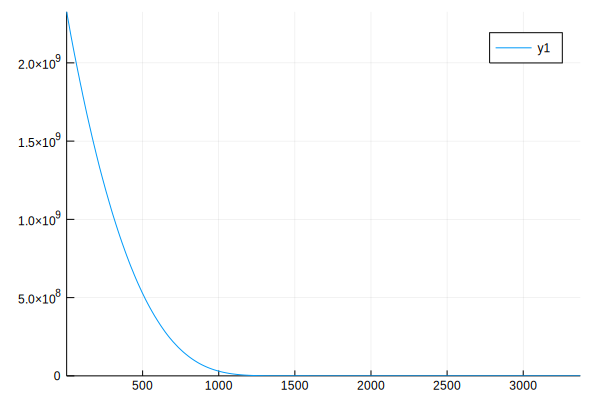

In [76]:
(t₀, dE) = findEquilibrium(1.0, 1.0, 0.5, 1.0, 1/32, 40)
@show t₀
T = size(dE,1)
plot(1:T,dE)

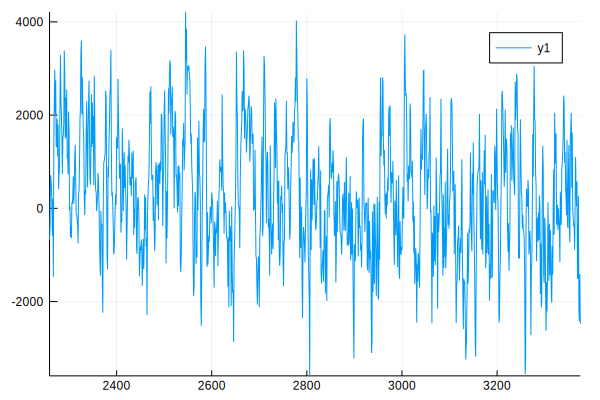

In [77]:
plot(t₀:T,dE[t₀:T])

### Debugging function part by part.

In [60]:
ψ₁ = State(40, 2, 1.0, 1.0, 0.5, 1.0)
ψ₂ = State(40, 1, 1.0, 1.0, 0.5, 1.0)
T = 1000
dE = zeros(T)
β = 1/32
ex = 1.5
di = 10


tₛ = 0    # The wanted t₀ does not exist at or before this position.
t₀ = T

for i = 1:T
    dE[i] = E(ψ₁)-E(ψ₂)
    mcSweep!(ψ₁, β)
    mcSweep!(ψ₂, β)
end

In [69]:
# Find the first occurence of dE <= 0 if it exists
t₀ = T
for i = (tₛ+1):T
    if dE[i] <= 0
        t₀ = i
        break
    end
end
t₀

2284

In [70]:
while T <= t₀
    # If we couldn't find a t₀ in dE we have to try and increase simulation time
    tₛ = T
    T = Int(ceil(T*ex))
    for i = (tₛ+1):T
        mcSweep!(ψ₁, β)
        mcSweep!(ψ₂, β)
        push!(dE, E(ψ₁) - E(ψ₂))
    end

    # Then we again see if we can find the first occurrence of dE <= 0 after tₛ
    t₀ = T
    for i = tₛ:T
        if dE[i] <= 0
            t₀ = i
            break
        end
    end

    # When the loop ends we should have the situation that T > t₀ where t₀ is the first occurrence
    # in dE where dE[t₀] <= 0
end

t₀ = 2284
T = 3405
size(dE, 1) = 3405
dE[t₀] = -1962.7846262365383


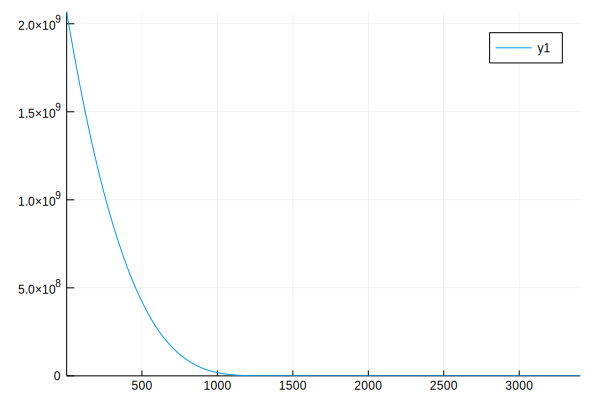

In [71]:
@show t₀
@show T
@show size(dE,1)
@show dE[t₀]
plot(1:T, dE)

In [72]:
# Now we make sure that T is large enough such that [1,T] includes an interval [t₀, t₀+t₀/div]
# so that an average can be performed
t_end = t₀ + Int(ceil(t₀/di))
while T <= t_end
    mcSweep!(ψ₁, β)
    mcSweep!(ψ₂, β)
    push!(dE, E(ψ₁) - E(ψ₂))
    T += 1
end
@show T
@show t_end

T = 3405
t_end = 2513


2513

In [73]:
# Now we calculate the average and standard deviation of dE over [t₀, T] and check if the
# average is within a standard deviation of 0 at which point t₀ and dE is returned
int = dE[t₀:T]
if abs(mean(int)) <= std(int)
    @show t₀
end
@show abs(mean(int))
@show std(int)

t₀ = 2284
abs(mean(int)) = 604.054150904035
std(int) = 1396.4077698155843


1396.4077698155843

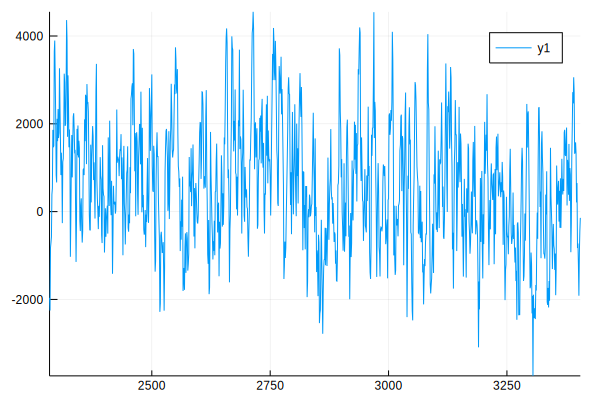

In [74]:
plot(t₀:T, dE[t₀:T])

In [68]:
# If we didn't find an interval that had an average close to 0 we assume this interval is ahead of us
# and start again with an increased T, setting the starting point tₛ to the end of the interval.
tₛ = T
T = Int(ceil(T*ex))

# Simulating new MCS
for i = (tₛ+1):T
    mcSweep!(ψ₁, β)
    mcSweep!(ψ₂, β)
    push!(dE, E(ψ₁) - E(ψ₂))
end

In [58]:
@show T
@show tₛ
@show size(dE,1)

T = 3855
tₛ = 2570
size(dE, 1) = 3855


3855

# Working on ignoring floating point errors in testing.

In [16]:
x = 225.0000000000097
y = 225.0
r = 1e-13
@show norm(x-y)
@show r*max(norm(x), norm(y))
isapprox(x,y,rtol=r,atol=0)

norm(x - y) = 9.691802915767767e-12
r * max(norm(x), norm(y)) = 2.250000000000097e-11


true

# Simulation control
To make it easier to control the simulation, we collect alle the knobs that we might want to turn in the simulation
in a separate type that we can then have as an input parameter.

In [4]:
struct SimulationControls
    N::Int64      # System size
    γ::Float64    # Order parameter amplitude
    g::Float64    # Gauge coupling
    ν::Float64    # Anisotropy constant
    f::Float64    # Magnetic filling fraction
    β::Float64    # Simulation temperature
end

# Autocorrelation function
Given an array of observables $[\mathcal{O}_i]$, its average $\langle\mathcal{O}\rangle$ and second moment
$\langle\mathcal{O}^2\rangle$, we find this arrays autocorrelation time by calculating the function
$$ \tau_{\mathcal{O}} = \sum_t\frac{1}{\langle\mathcal{O}^2\rangle - \langle\mathcal{O}\rangle^2}\Big[\frac{1}{M-t}\sum_{i=1}^{M-t}\mathcal{O}_i\mathcal{O}_{i+t} - \langle\mathcal{O}\rangle^2\Big] $$

In [5]:
function autocorrTime(O::Array{Float64, 1}, av::Float64, secondMom::Float64)
    M = size(O,1)
    τₒ = 0.0
    ss = 0.0
    
    # Enter first sum
    for t=0:(M-1)
        
        ss = 0.0
        # Enter second sum
        for i = 1:(M-t)
            ss += O[i]*O[i+t]
        end
        τₒ += ss/(M-t) - av^2
    end
    return τₒ/(secondMom - av^2)
end     

autocorrTime (generic function with 1 method)

### Alternative version by factorization
We could try to split this up so we have a function just calculating the autocorrelation

In [133]:
function autocorr(t::Int64, O::Array{Float64, 1}, M::Int64, av::Float64, sm::Float64)
    sum = 0.0
    for i=1:(M-t)
        sum += O[i]*O[i+t]
    end
    return (sum/(M-t) - av^2)/(sm - av^2)
end

autocorr (generic function with 1 method)

In [141]:
function autocorrTime2(O::Array{Float64, 1}, av::Float64, sm::Float64)
    sum = 0.0
    M = size(O,1)
    for t=0:(M-1)
        sum += autocorr(t, O, M, av, sm)
    end
    return sum
end

autocorrTime2 (generic function with 1 method)

In [155]:
using Base.Test
O = rand(10000)
sm = 0
for t = O
    sm += t^2
end
sm = sm/size(O,1)
@test isapprox(autocorrTime(O, mean(O), sm), autocorrTime2(O, mean(O), sm), atol=0, rtol=1e-14)

Test Passed

### Benchmarking of alternative

In [156]:
using BenchmarkTools
@benchmark autocorrTime($O, $mean(O), $sm)

BenchmarkTools.Trial: 
  memory estimate:  48 bytes
  allocs estimate:  3
  --------------
  minimum time:     47.525 ms (0.00% GC)
  median time:      47.905 ms (0.00% GC)
  mean time:        47.982 ms (0.00% GC)
  maximum time:     51.017 ms (0.00% GC)
  --------------
  samples:          105
  evals/sample:     1

In [157]:
@benchmark autocorrTime2($O, $mean(O), $sm)

BenchmarkTools.Trial: 
  memory estimate:  48 bytes
  allocs estimate:  3
  --------------
  minimum time:     47.504 ms (0.00% GC)
  median time:      47.780 ms (0.00% GC)
  mean time:        48.517 ms (0.00% GC)
  maximum time:     55.822 ms (0.00% GC)
  --------------
  samples:          104
  evals/sample:     1

# Taking thermal average over the planar structure function
After equilibrating a state, we start taking the average over the planar structure function.

In [80]:
sim = SimulationControls(30, 1.0, 1.0, 1.0, 1.0, 1.0)

SimulationControls(1.0, 1.0, 1.0, 1.0, 1.0, 30)

In [6]:
function structureFunctionPlussAvg(k::Array{Int64,1}, sim::SimulationControls, M::Int64, Δt::Int64)
    S = zeros(M)
    secondMoment = 0
    # Finding a state that has reached thermal equilibrium
    (t₀, dE, ψ, ψ₂) = findEquilibrium(sim.γ, sim.g, sim.ν, sim.f, sim.β, sim.N)
    
    # Loop over M measurements
    for m = 1:M
        
        # Take Δt MCS
        for i = 1:Δt
            mcSweep!(ψ, sim.β)
        end
        
        # Make a measurement
        secondMoment = (S[m] = structureFunctionPluss(k, ψ))^2
    end
    
    # Return average, variance and auto-correlation time estimates
    av = mean(S)
    secondMoment = secondMoment/M
    τₒ = autocorrTime(S, av, secondMoment)
    
    return (av, secondMoment, τₒ)
end

structureFunctionPlussAvg (generic function with 1 method)

### Testing

In [7]:
sim2 = SimulationControls(40, 1.0, 1.0, 0.5, 1.0, 1/32)
structureFunctionPlussAvg([0,0], sim2, 100, 100)

(1.6174264990065624e-27, 4.016336593280212e-57, -20.459197876230334)